In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from datetime import datetime, timedelta
fd = '/Users/linlin/Desktop/FerryILP/ILPimplementation/'

version = '6.4.2'

# Inputs and functions

In [2]:
task_colors = {
'Waiting': 'grey',
'Crew Break': 'skyblue',
'Charging': 'yellow',
'F2 - Taronga Zoo (off peak)': '#1b412f',
'F2 - Zoo/Mosman (Peak)': '#1b412f',
'F4 - Pyrmont Bay': '#8bc540',
'F5 - Neutral Bay': '#255d3d',
'F6 - Mosman (off peak)': '#25ad4b',
'F6 - Mosman (peak)': '#25ad4b',
'F7 - Double Bay': '#22b581',
'F8 - Cockatoo Island': '#4b5f2b',
'F9 - Rose Bay': '#009c4c',
'F9 - Watsons Bay': '#009c4c',
'F11 - Blackwattle Bay': '#0e744c'}

vessel_mapping = {
    "V1": "V1", "V2": "V2", "V3": "V3", "V4": "V4", "V5": "V5", "V6": "V6", 
    "V7": "V7", "V8": "V8", "V9": "V9", "V10": "V10", "V11": "V11", 
    "V12": "V12", "V13": "V13", "V14": "V14", "V15": "V15", "V16": "V16", 
    "V17": "V17", "V18": "V18", "V19": "V19"
}

In [3]:

def visualise_vessel_itinerarie(vessel,figsize=(20,1), dpi=600, display_start="05:30", display_end="11:30"):
    file_path = fd + f'vessel_itineraries/version{version}/vessel_{vessel}_itinerary.csv'
    # Load the data
    df = pd.read_csv(file_path)
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='%H:%M')
    df['End_Time'] = pd.to_datetime(df['End_Time'], format='%H:%M')
    
    # Convert display_start and display_end to datetime objects for filtering
    display_start_dt = datetime.strptime(display_start, '%H:%M')
    display_end_dt = datetime.strptime(display_end, '%H:%M')
    
    # Filter the data to only include tasks within the display range
    df = df[(df['End_Time'] >= display_start_dt) & (df['Start_Time'] <= display_end_dt)]
    
    # Sort tasks by start time
    df = df.sort_values(by='Start_Time')

    # Plot each task
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Initialize variable to track the end of the last task
    last_end_time = None
    
    for idx, row in df.iterrows():
        start_time = mdates.date2num(row['Start_Time'])
        end_time = mdates.date2num(row['End_Time'])
        duration = end_time - start_time
        
        # Skip plotting tasks that start before display_start
        if row['Start_Time'] < display_start_dt:
            continue

        # Check for a gap between the current start time and last end time
        if last_end_time is not None and start_time > last_end_time:
            # Plot a hatched rectangle to fill the vacancy (rebalancing task)
            vacancy_duration = start_time - last_end_time
            vacancy_rect = plt.Rectangle(
                (last_end_time, 0.6), 
                vacancy_duration, 
                0.8, 
                facecolor='none',  # No solid fill
                edgecolor='k', 
                hatch='//',  # Diagonal hatch pattern
                alpha=0.7
            )
            ax.add_patch(vacancy_rect)

        # Plot the current task
        task_color = task_colors.get(row['Task'], 'grey')  # Fallback color if task not in task_colors
        rect = plt.Rectangle((start_time, 0.6), duration, 0.8, facecolor=task_color, edgecolor='k', label=row['Task'], alpha=0.7)
        ax.add_patch(rect)

        # Display Start_Wharf and/or End_Wharf based on task type
        if row['Task'] in ['Waiting', 'Crew Break', 'Charging']:
            ax.text(start_time + duration / 2, 1, row['Start_Wharf'],
                    horizontalalignment='center', verticalalignment='center', fontsize=12)
        else:
            ax.text(start_time + duration / 2, 1, f"{row['Start_Wharf']} --> {row['End_Wharf']}",
                    horizontalalignment='center', verticalalignment='center', fontsize=12)

        # Update last_end_time to current task's end time
        last_end_time = end_time

    # Formatting the chart
    ax.set_ylim(0.5, 1.5)
    ax.set_yticks([])
    
    # Set the x-axis limits based on specified display_start and display_end
    ax.set_xlim(
        mdates.date2num(display_start_dt),
        mdates.date2num(display_end_dt)
    )
    
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    # ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

    ax.set_title(f'Vessel {vessel} Itinerary Timelines', fontsize = 12)

    # Add custom legend for rebalancing task with hatch pattern
    vacancy_legend = Patch(facecolor='none', edgecolor='k', hatch='//', label='Rebalancing')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    by_label['Rebalancing'] = vacancy_legend  # Add rebalancing legend entry
    ax.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1.01, 1), fontsize = 12)

    plt.grid(True)
    # plt.tight_layout()
    plt.show()

In [4]:
def visualise_wharf_utilization(wharf, figsize=(20,2), dpi=600, display_start='5:30', display_end='11:30'):

    file_path = fd + f'wharf_utilizations/version{version}/wharf_{wharf}_utilization.csv'
    # Load data
    df = pd.read_csv(file_path)
    df[['Start_Time', 'End_Time']] = df['Time'].str.split('-', expand=True)
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='%H:%M')
    df['End_Time'] = pd.to_datetime(df['End_Time'], format='%H:%M')

    # Filter data for the specified time range
    if display_start and display_end:
        display_start = pd.to_datetime(display_start, format='%H:%M')
        display_end = pd.to_datetime(display_end, format='%H:%M')
        df = df[(df['Start_Time'] >= display_start) & (df['End_Time'] <= display_end)]

    # Sort the dataframe by Wharf, Vessel, Task, and Start_Time
    df = df.sort_values(by=['Wharf', 'Vessel', 'Task', 'Start_Time'])

    # Combine consecutive rows with the same Task and Vessel that are contiguous in time
    combined_tasks = []
    current_task = None

    for _, row in df.iterrows():
        if (current_task is None or 
            row['Task'] != current_task['Task'] or 
            row['Vessel'] != current_task['Vessel'] or 
            row['Start_Time'] > current_task['End_Time']):
            # Start a new task block
            if current_task is not None:  # Only append if current_task is defined
                combined_tasks.append(current_task)
            current_task = row.copy()
        else:
            # Extend the current task block if overlapping or contiguous
            current_task['End_Time'] = max(current_task['End_Time'], row['End_Time'])

    # Add the last task block
    if current_task is not None:
        combined_tasks.append(current_task)

    # Create a new dataframe from the combined tasks
    combined_df = pd.DataFrame(combined_tasks)

    # Determine the min and max times for dynamic display range
    min_time = combined_df['Start_Time'].min()
    max_time = combined_df['End_Time'].max()

    # Set up the plot
    fig, ax = plt.subplots(figsize= figsize, dpi= dpi)
    wharf_row_tracker = {}
    legend_items = {}  # To store task colors for the legend
    
    # Plot each combined task, managing rows to avoid overlaps
    for idx, row in combined_df.iterrows():
        start_time = mdates.date2num(row['Start_Time'])
        end_time = mdates.date2num(row['End_Time'])
        duration = end_time - start_time

        # Determine the row based on overlapping times for the same Wharf
        wharf = row['Wharf']
        if wharf not in wharf_row_tracker:
            wharf_row_tracker[wharf] = [[]]  # Initialize with an empty list for the first row

        # Find the next available row to avoid overlap
        row_num = None
        for i, row_intervals in enumerate(wharf_row_tracker[wharf]):
            if all(start_time >= e or end_time <= s for s, e in row_intervals):
                row_num = i
                wharf_row_tracker[wharf][i].append((start_time, end_time))
                break
        # If no row is available, create a new row
        if row_num is None:
            row_num = len(wharf_row_tracker[wharf])
            wharf_row_tracker[wharf].append([(start_time, end_time)])

        # Plot the rectangle using existing task_colors
        task_color = task_colors.get(row['Task'], 'orange')  # Use task_colors for the task color
        ax.add_patch(plt.Rectangle(
            (start_time, 0.8 + row_num * 0.5), 
            duration, 
            0.5, 
            facecolor=task_color, 
            edgecolor='k', 
            alpha=0.7
        ))

        # Add vessel name as text
        ax.text(start_time + duration / 2, 1 + row_num * 0.5, row['Vessel'],  # Use original vessel name
                horizontalalignment='center', verticalalignment='center', fontsize=12)

        # Add task to legend items if not already added
        if row['Task'] not in legend_items:
            legend_items[row['Task']] = plt.Rectangle((0, 0), 1, 1, facecolor=task_color, edgecolor='k', alpha=0.7)

    # Formatting the chart
    ax.set_ylim(0.5, 1.5 + 0.5 * len(wharf_row_tracker[wharf]))
    ax.set_yticks([])
    ax.set_xlim(mdates.date2num(display_start or min_time), mdates.date2num(display_end or max_time))

    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1)) 
    # ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

    ax.set_title(f'Berth {wharf} Utilisation Timeline', fontsize=12)

    # Add legend to the plot
    ax.legend(legend_items.values(), legend_items.keys(), loc='upper left', bbox_to_anchor=(1.01, 1.2),fontsize = 12)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
def visualise_vessel_battery(vessel,figsize=(60,4), dpi=200, display_start="05:30", display_end="11:30"):
    file_path = f'{fd}battery_change/version{version}/vessel_{vessel}_battery.csv'

    # Read the CSV file
    df = pd.read_csv(file_path)

    # Convert 'Time' column to datetime format
    df['Time'] = df['Time'].apply(lambda x: datetime.strptime(x, '%H:%M'))

    # Shift all times in the DataFrame by one unit (e.g., 1 hour)
    df['Time'] = df['Time'] + timedelta(minutes=5)  # Shift right by 60 minutes (1 hour)

    # Convert string times to datetime objects
    start_time = datetime.strptime(display_start, '%H:%M')
    end_time = datetime.strptime(display_end, '%H:%M')

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    # Set x-axis limits manually
    plt.xlim(start_time, end_time)
    plt.ylim(0, 1)

    # Plot the data
    plt.scatter(df['Time'], df['Value'], color='orange', s=20, label='Battery Points')  # Scatter plot
    plt.plot(df['Time'], df['Value'], color='orange', linestyle='-', linewidth=3, label='Battery Level')

    # Add value labels only for points within the specified time range
    for i, row in df.iterrows():
        if start_time <= row['Time'] <= end_time:  # Check if within limits
            plt.text(row['Time'], row['Value'] + 0.02, f"{row['Value']:.2f}", 
                    fontsize=16, ha='center', va='bottom', color='black')

    # Add a horizontal line at y=0.5
    safety_min = 0.5
    plt.axhline(safety_min, color='red', linestyle='--', linewidth=2, label='Safety Minimum Allowance')

    # Additional settings for the figure
    ax.set_ylabel("Battery Percentage", fontsize=20)
    # Set x-axis formatter and locator
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format for hours and minutes
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))   # Set major ticks every hour

    ax.tick_params(axis='x', labelsize=20)  # Set fontsize for x-axis
    ax.tick_params(axis='y', labelsize=0)  # Set fontsize for y-axis (optional)

    # Grid lines
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_title(f'veseel {vessel} battery Level', fontsize=12)

    # Legend
    plt.legend(fontsize=12,loc = "lower right")

    # Show the plot
    plt.show()

# Visulization Test

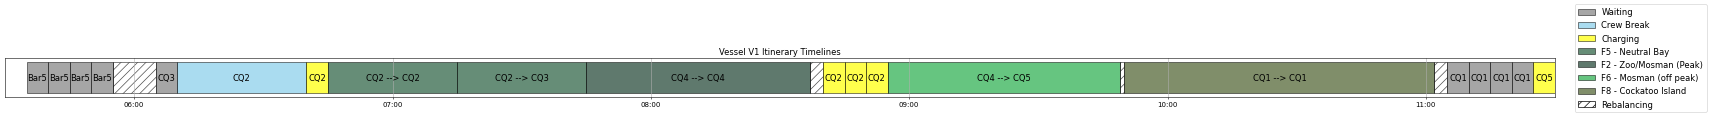

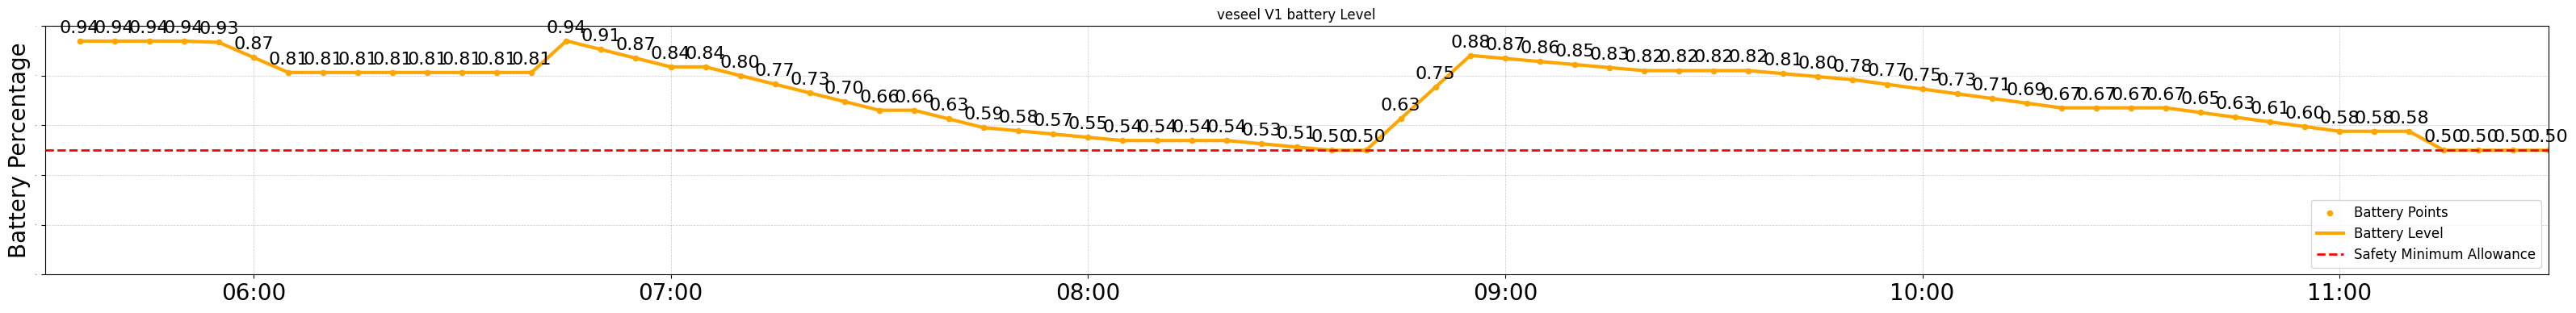

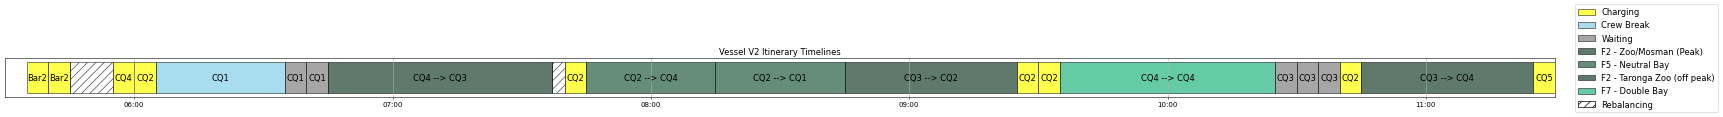

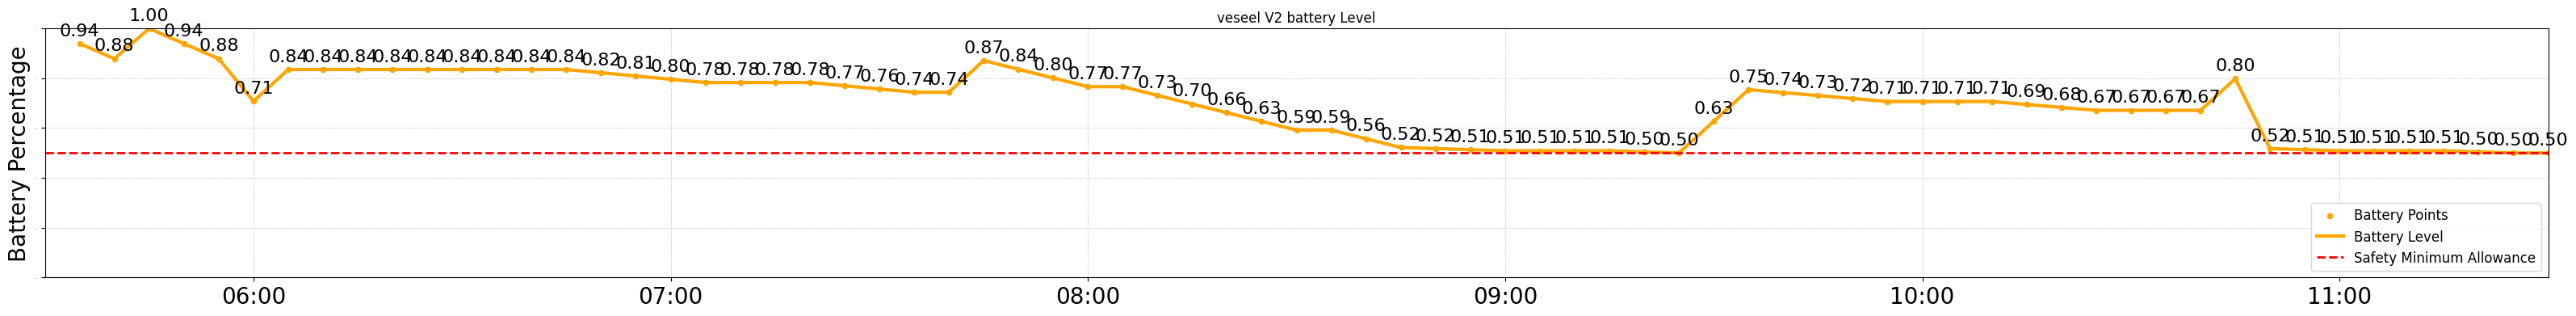

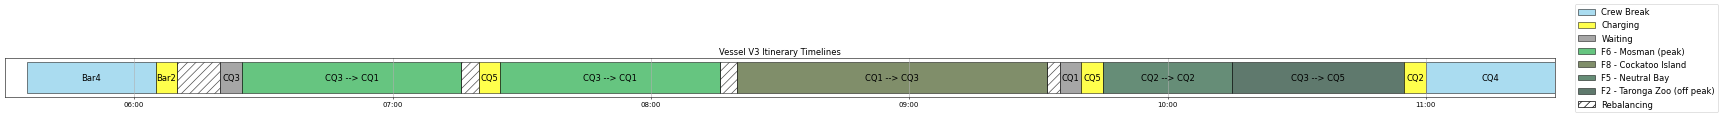

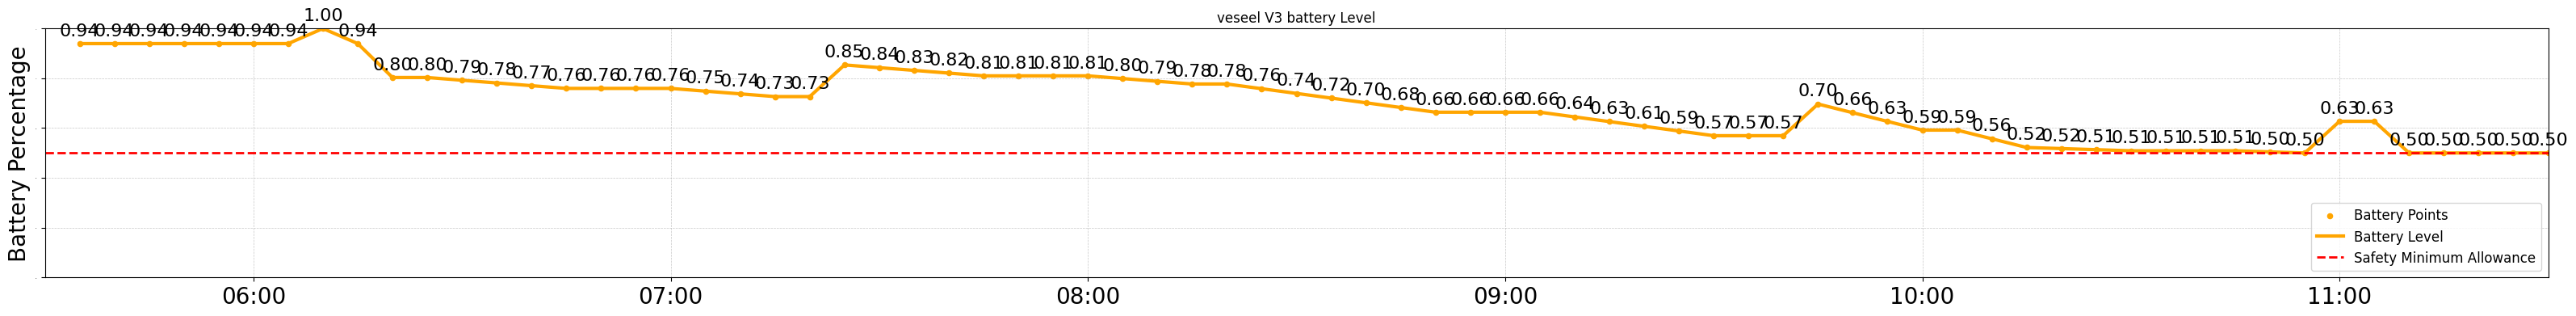

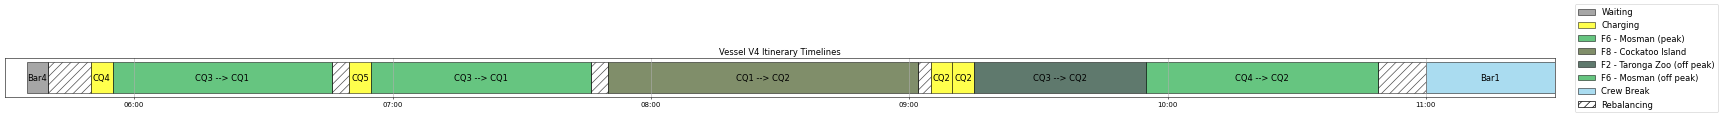

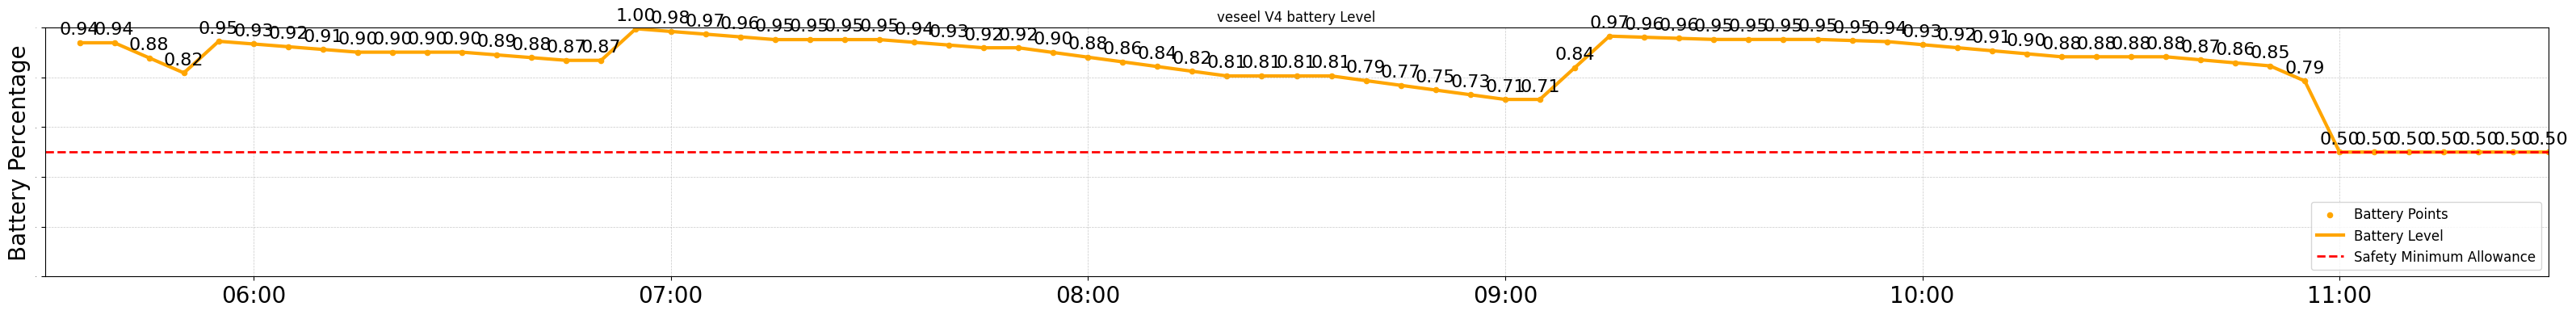

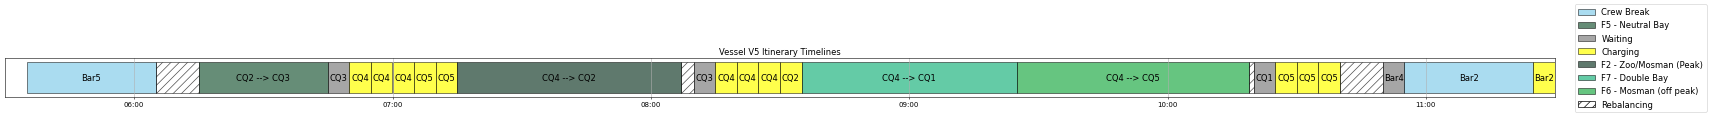

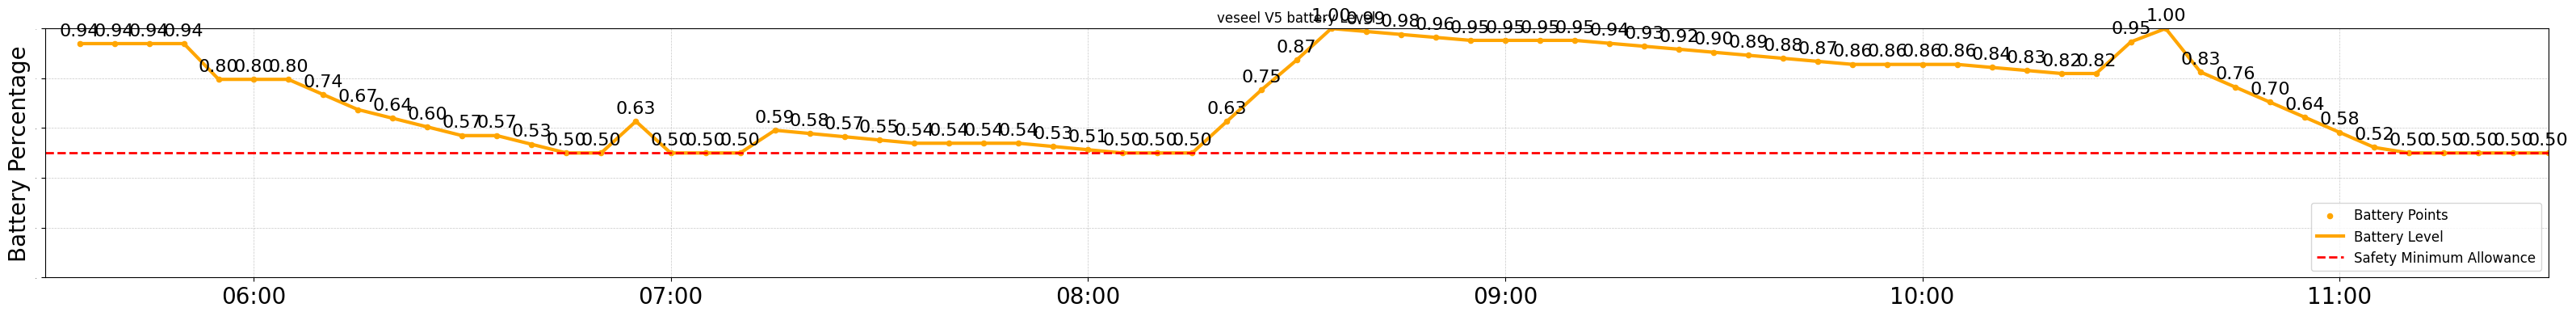

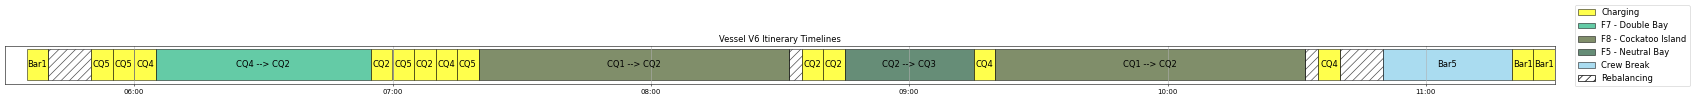

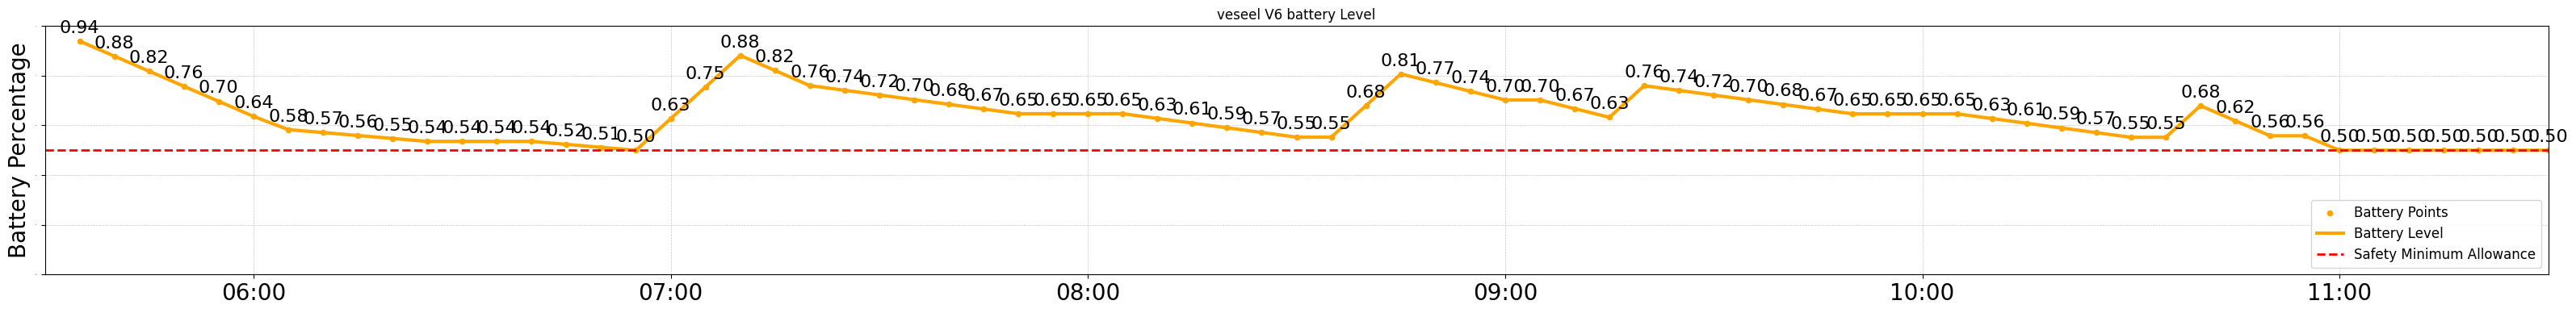

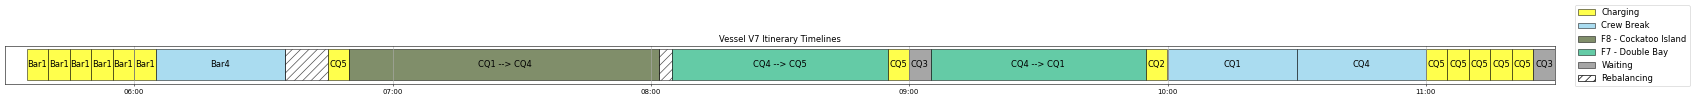

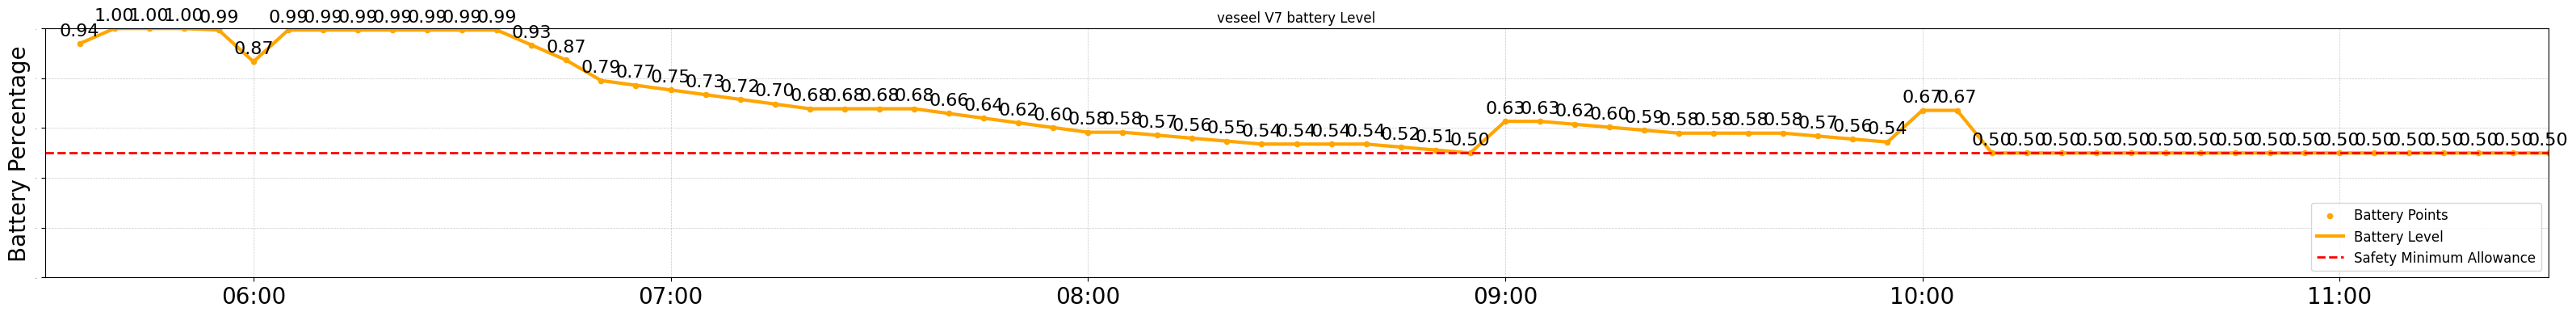

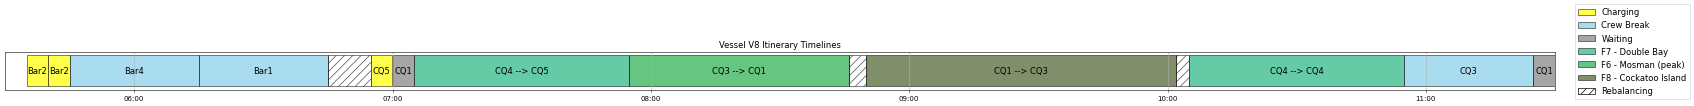

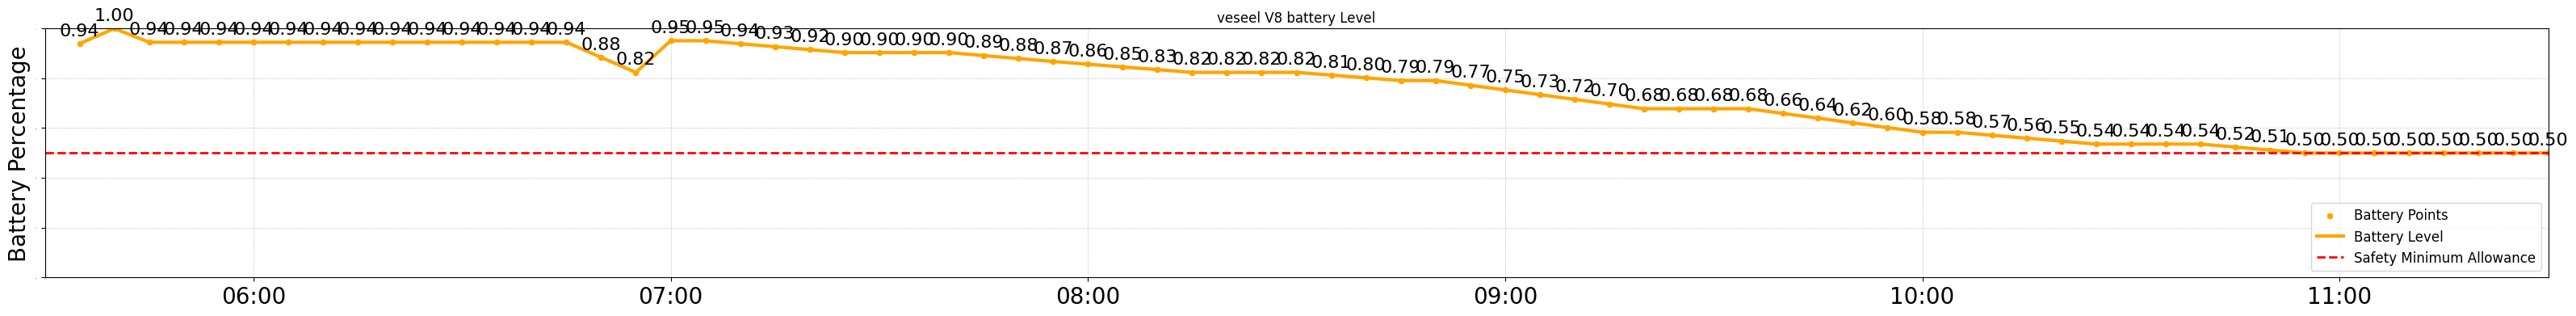

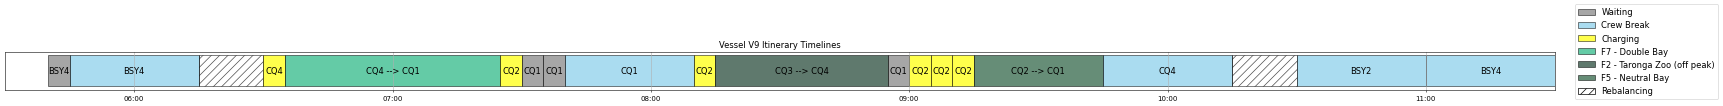

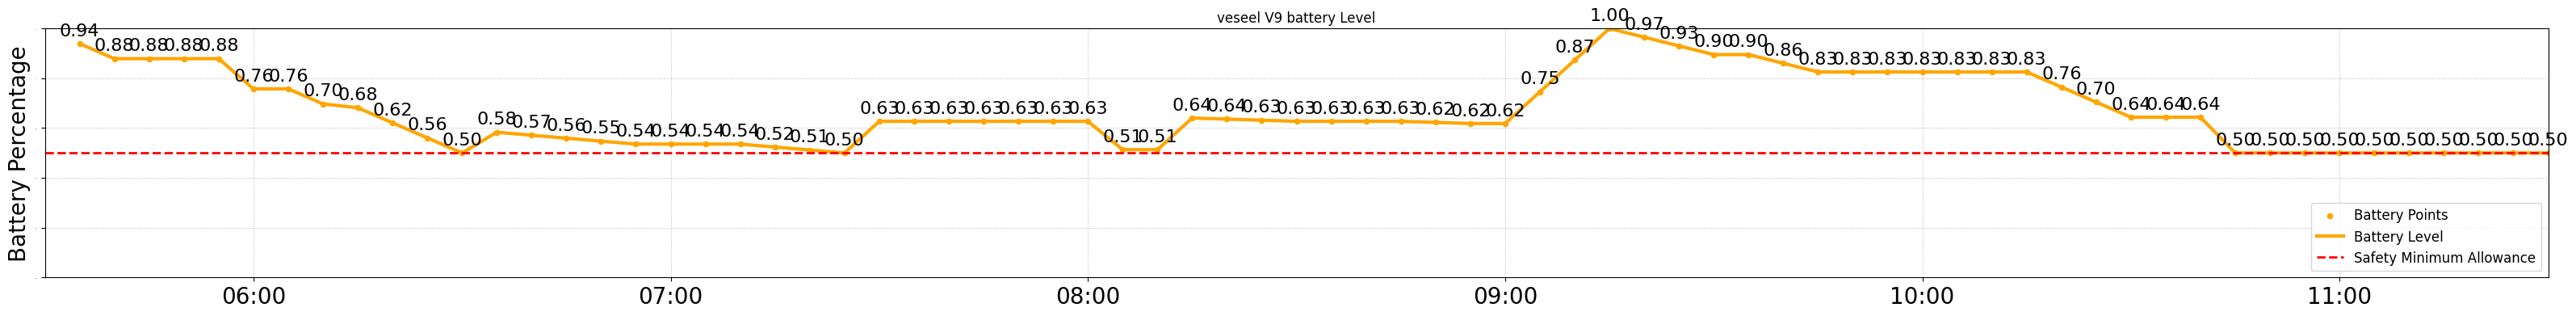

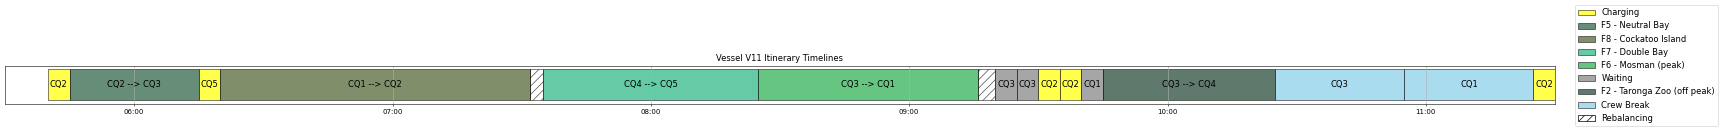

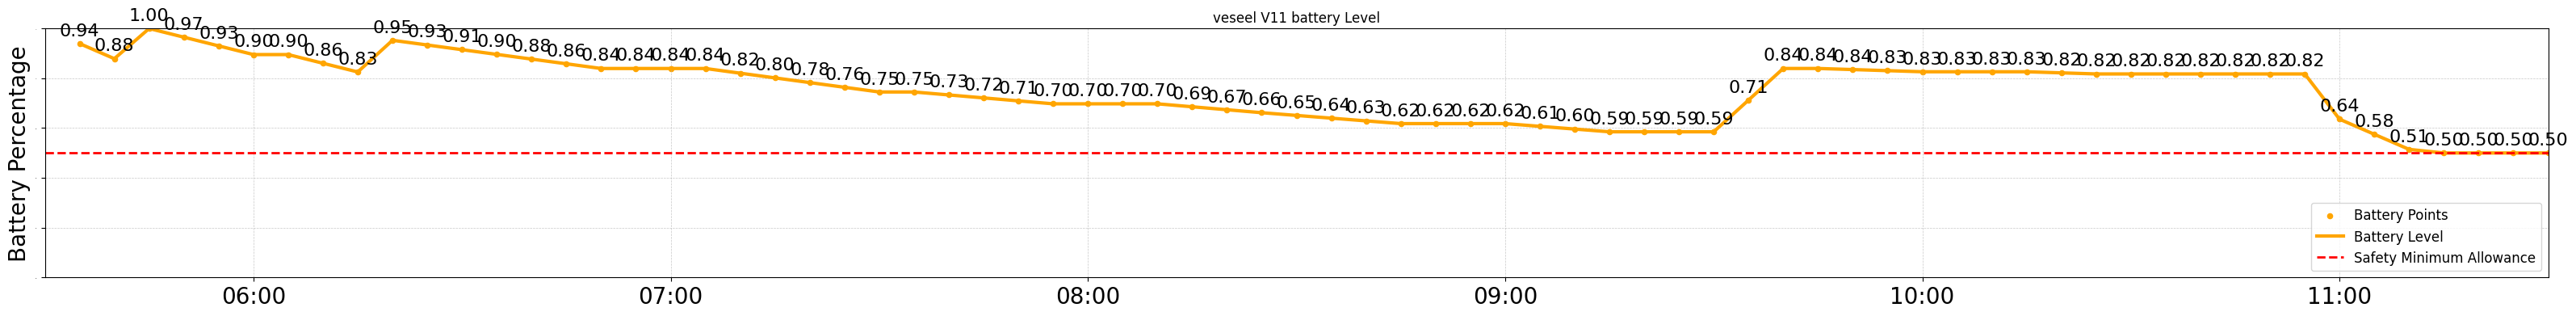

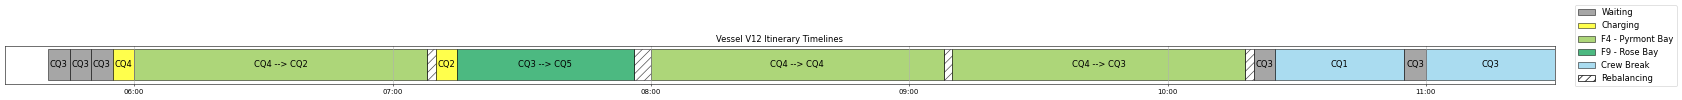

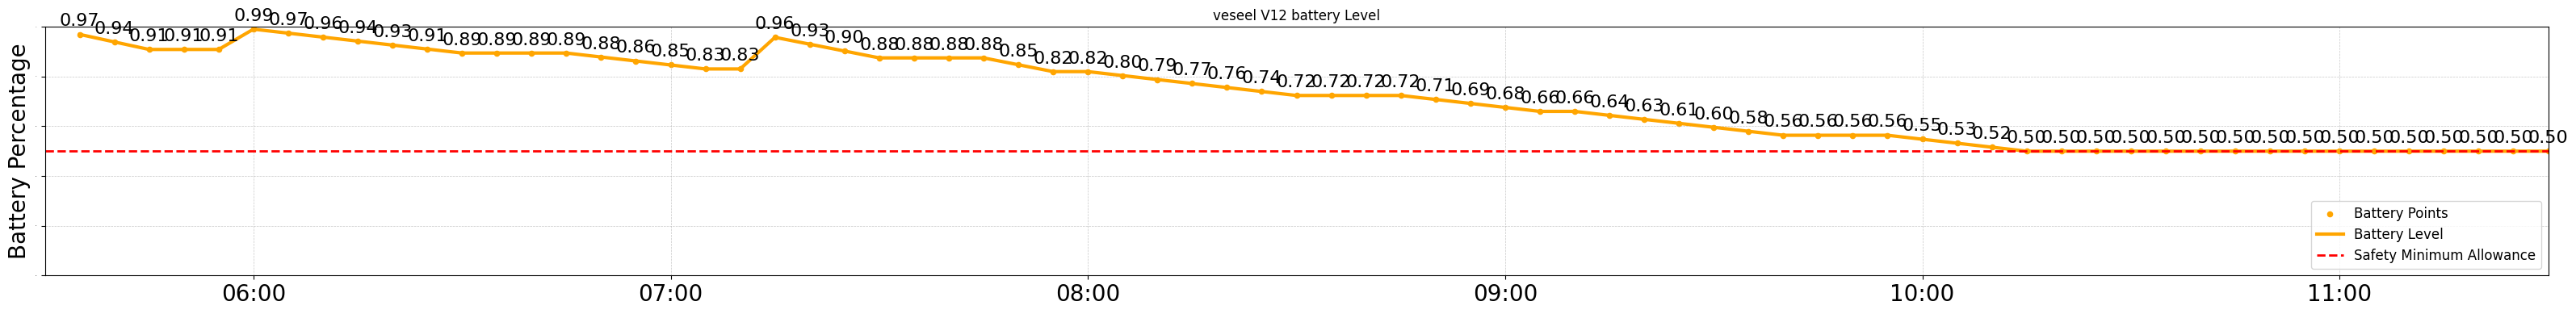

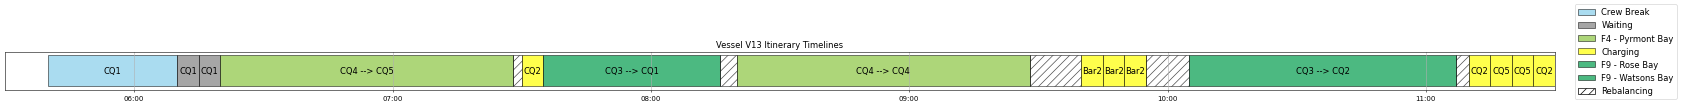

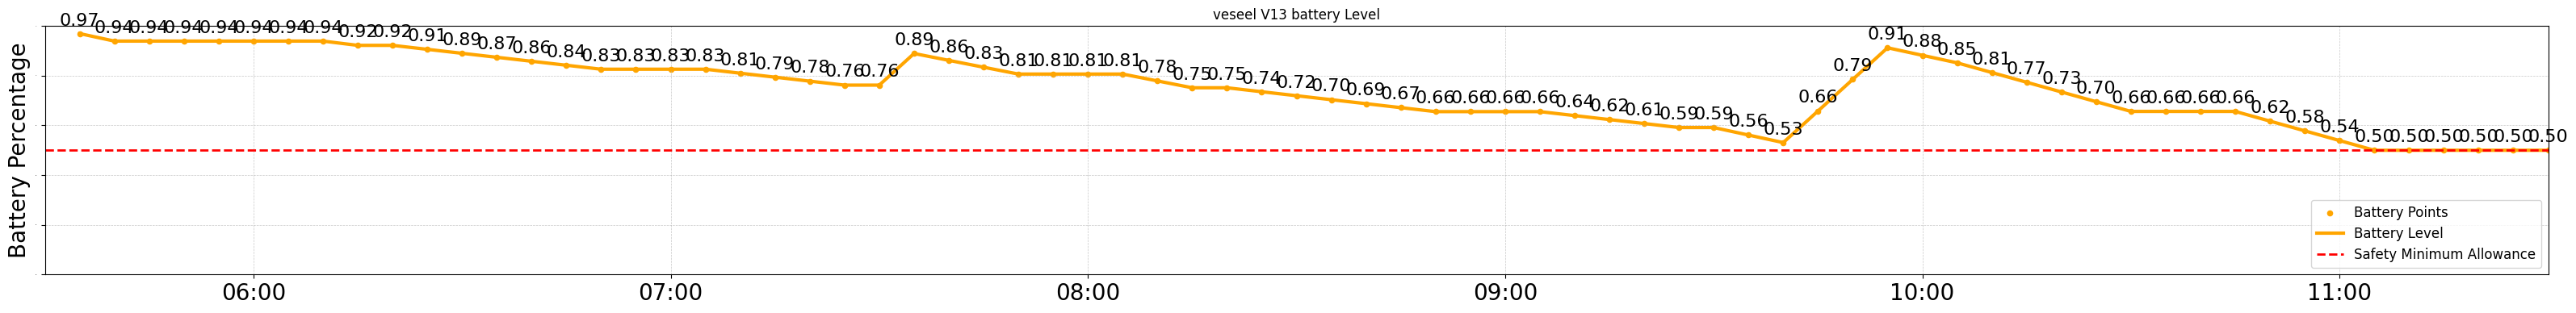

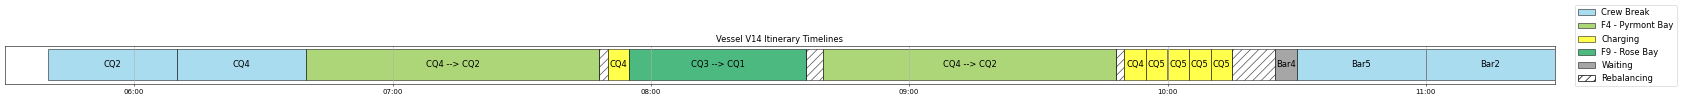

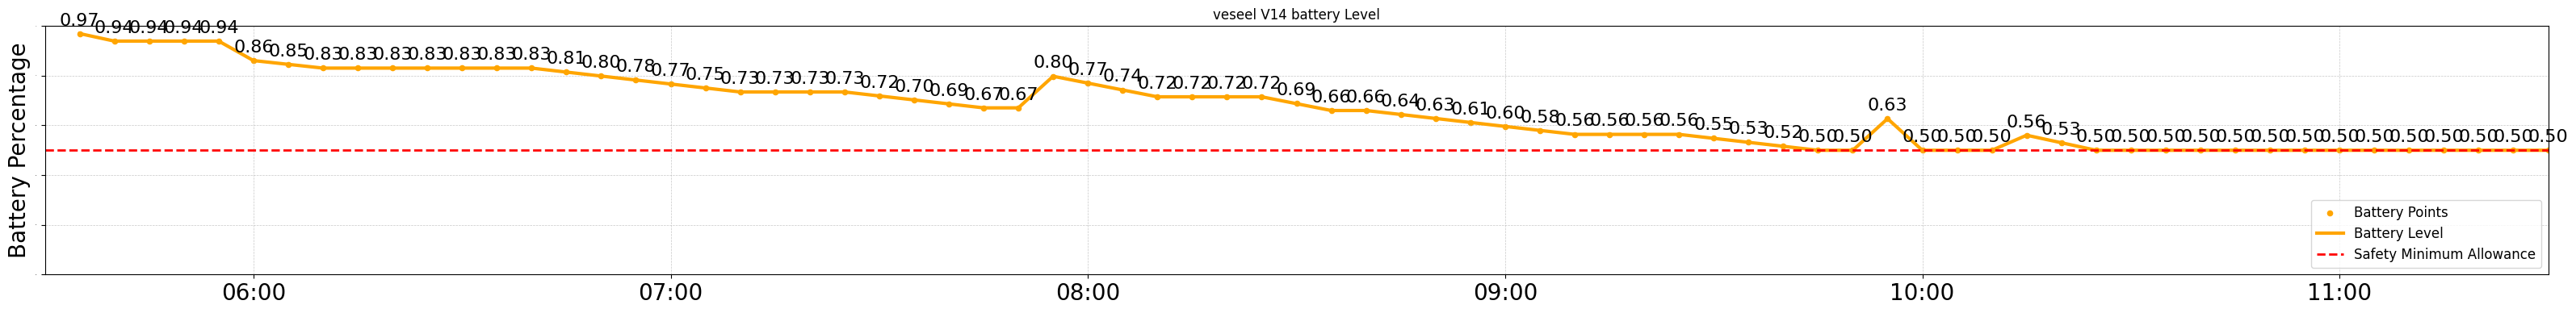

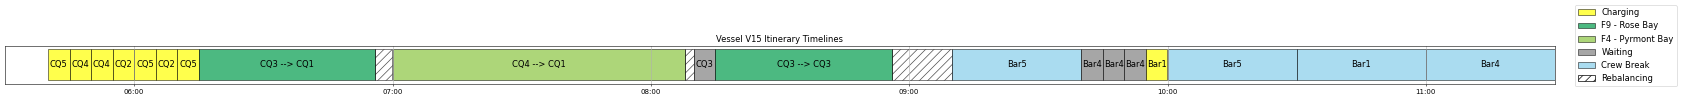

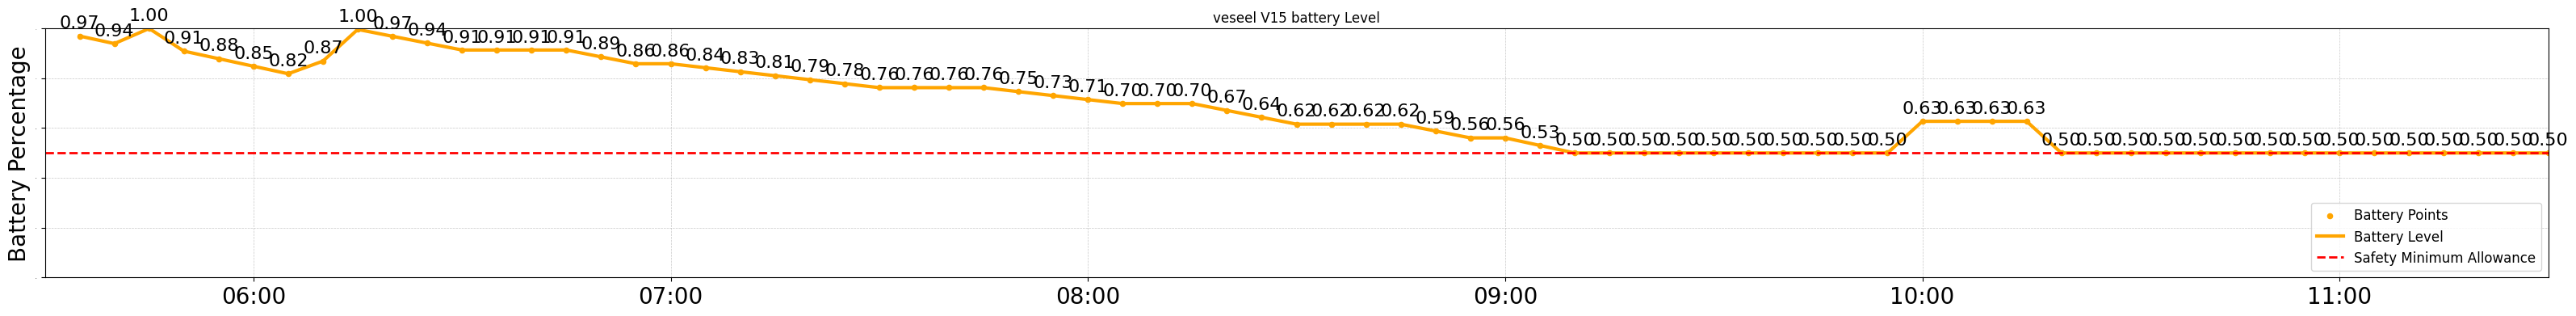

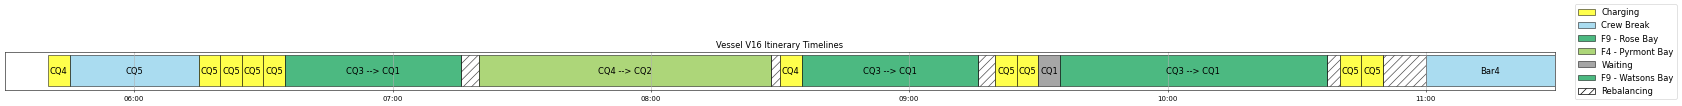

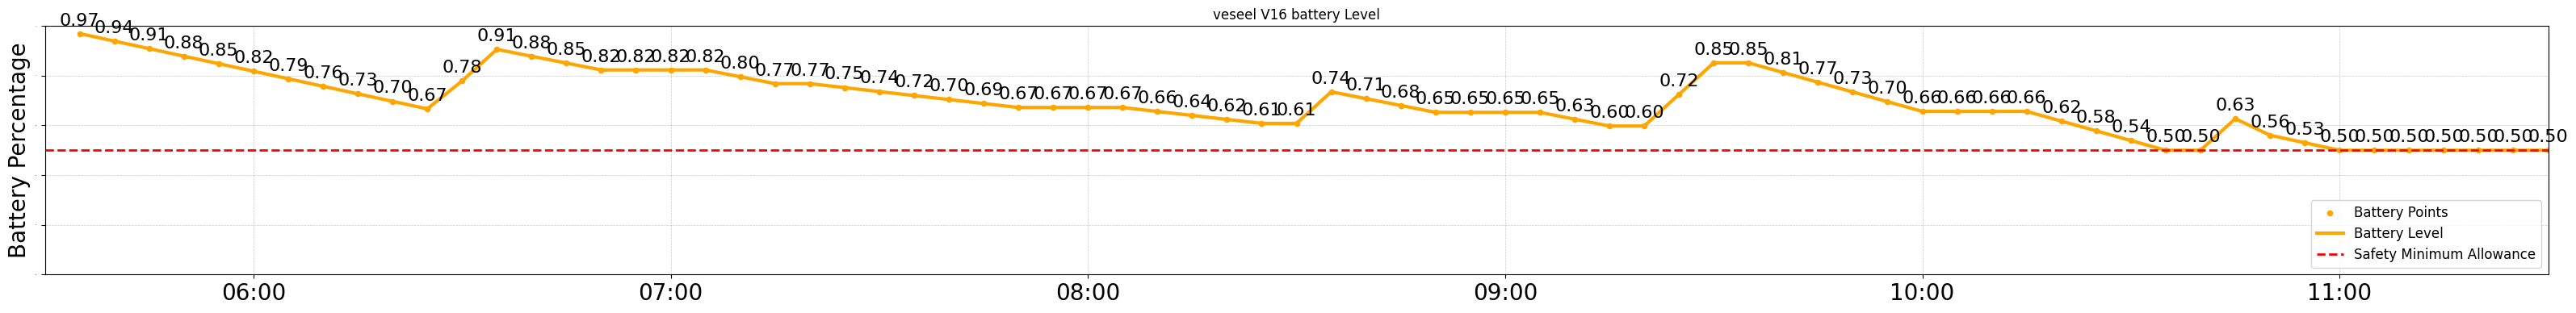

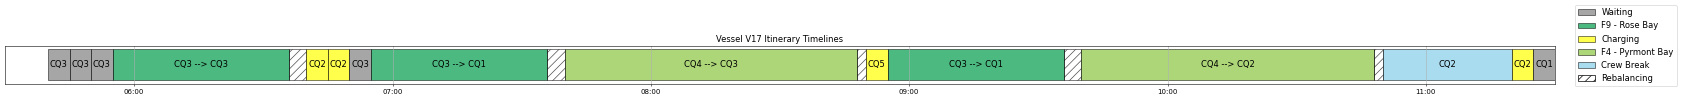

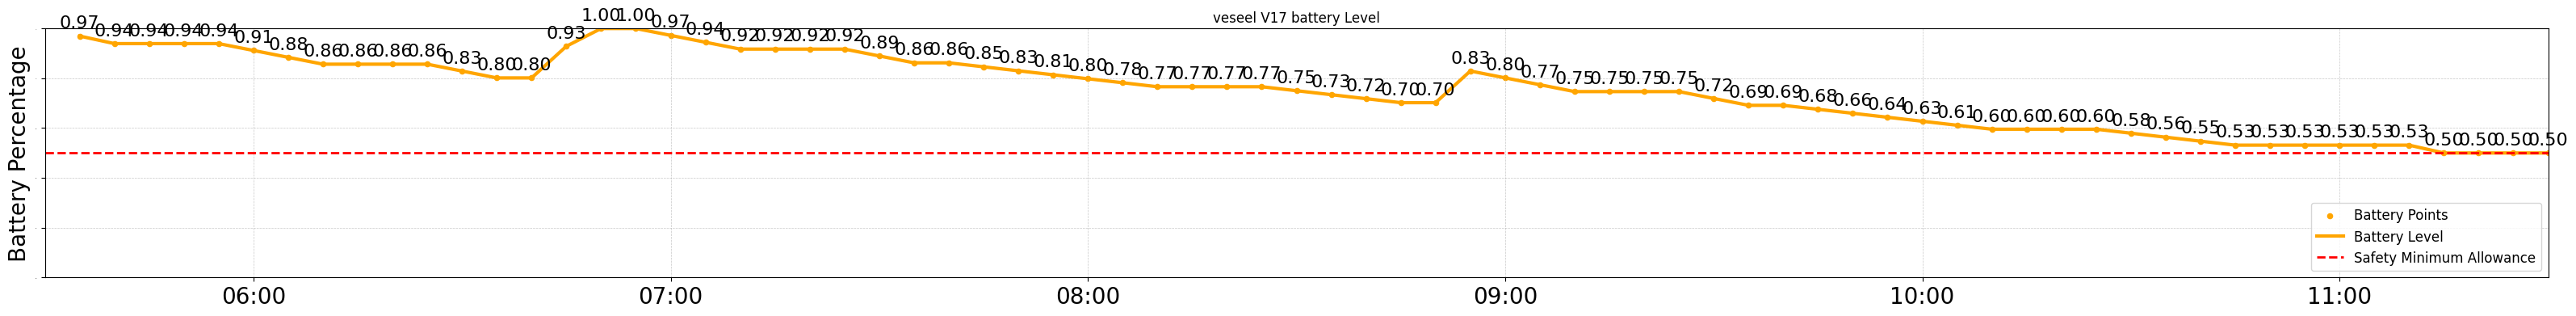

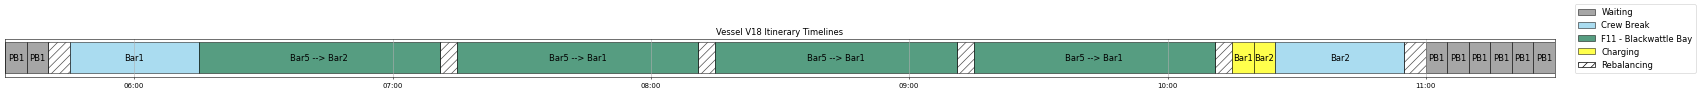

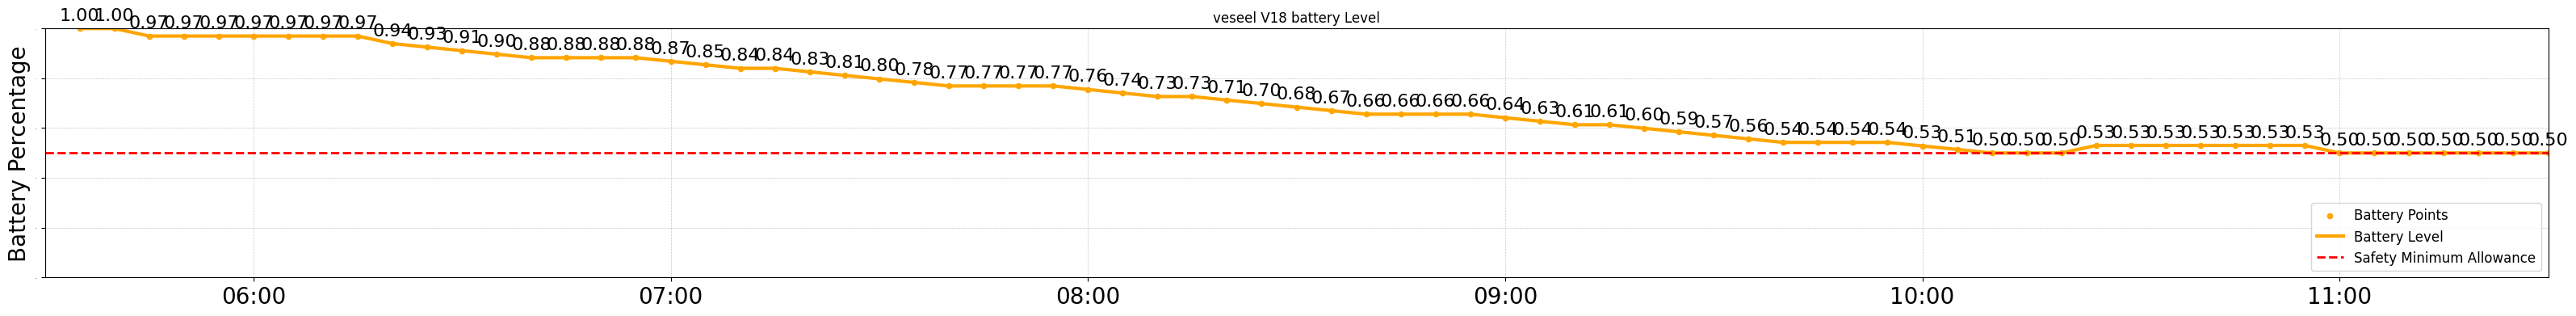

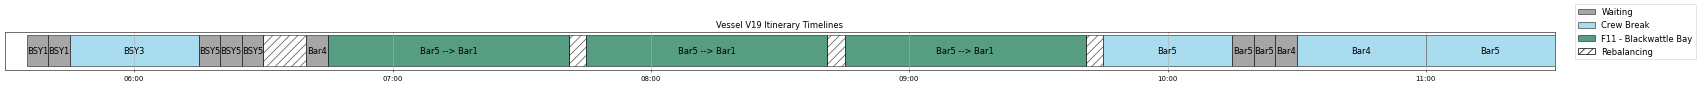

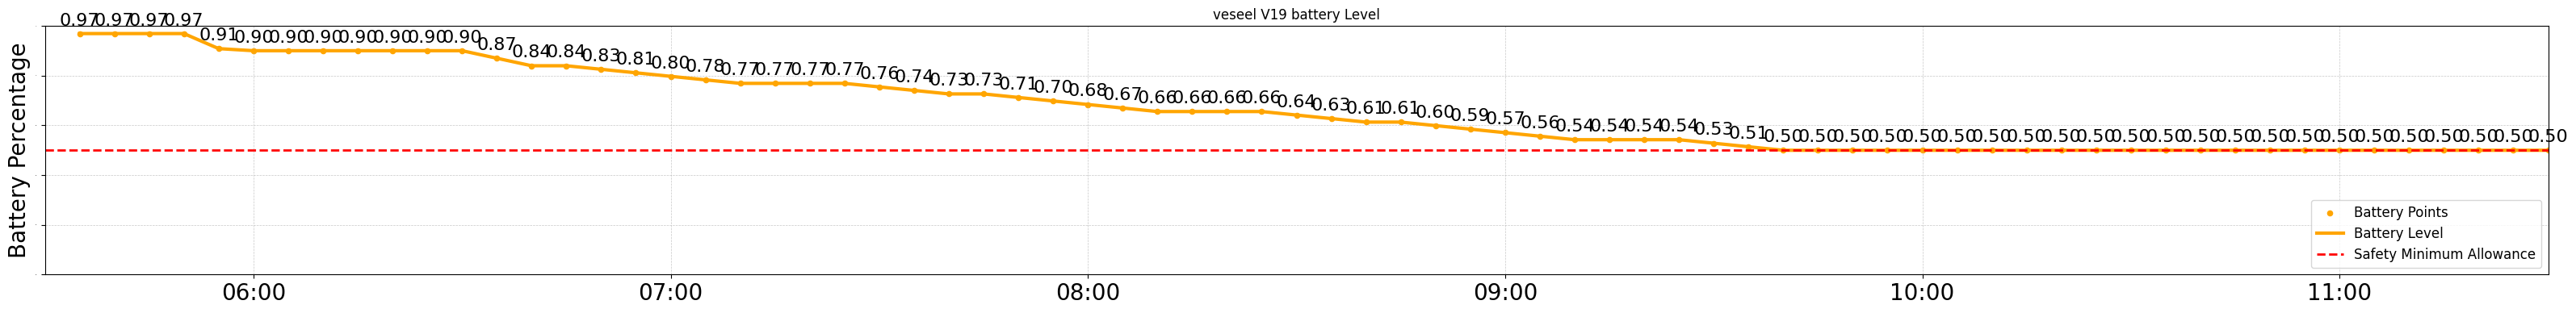

In [18]:
for i in range(19):
    if i != 9:
        visualise_vessel_itinerarie(f'V{i+1}',figsize=(40,1), dpi=50)
        visualise_vessel_battery(f'V{i+1}', figsize=(40,4), dpi=100)#, display_start="08:10", display_end="09:00")

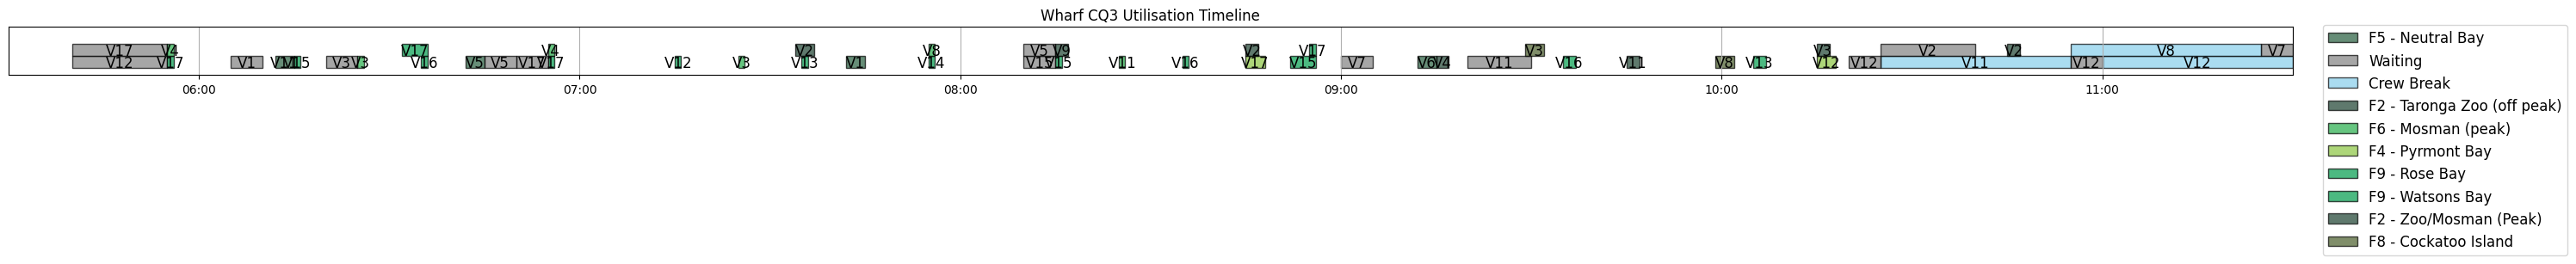

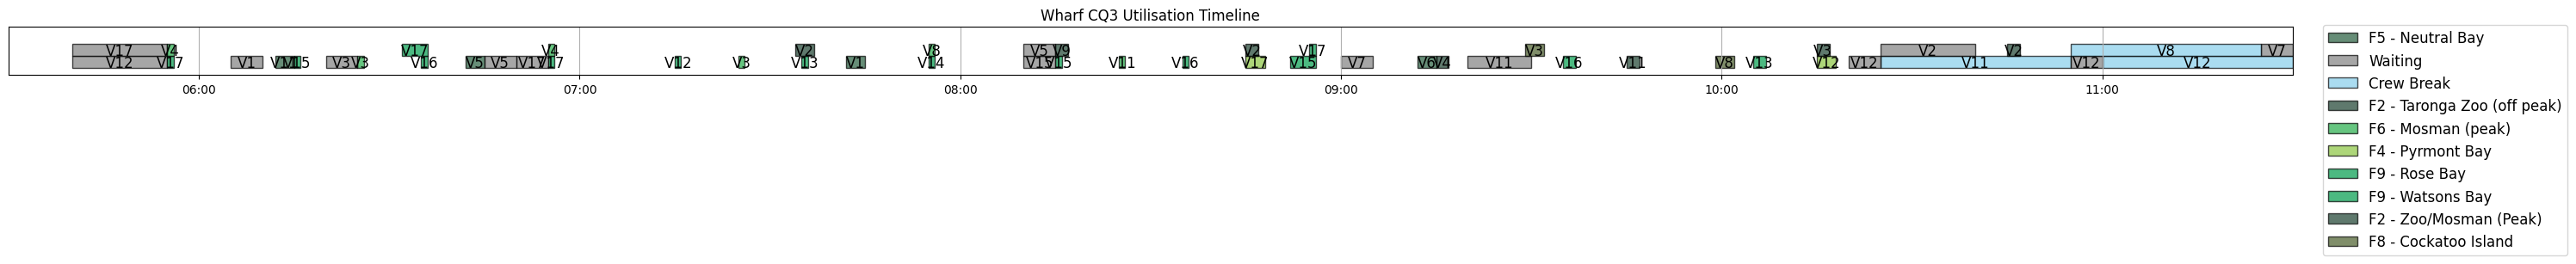

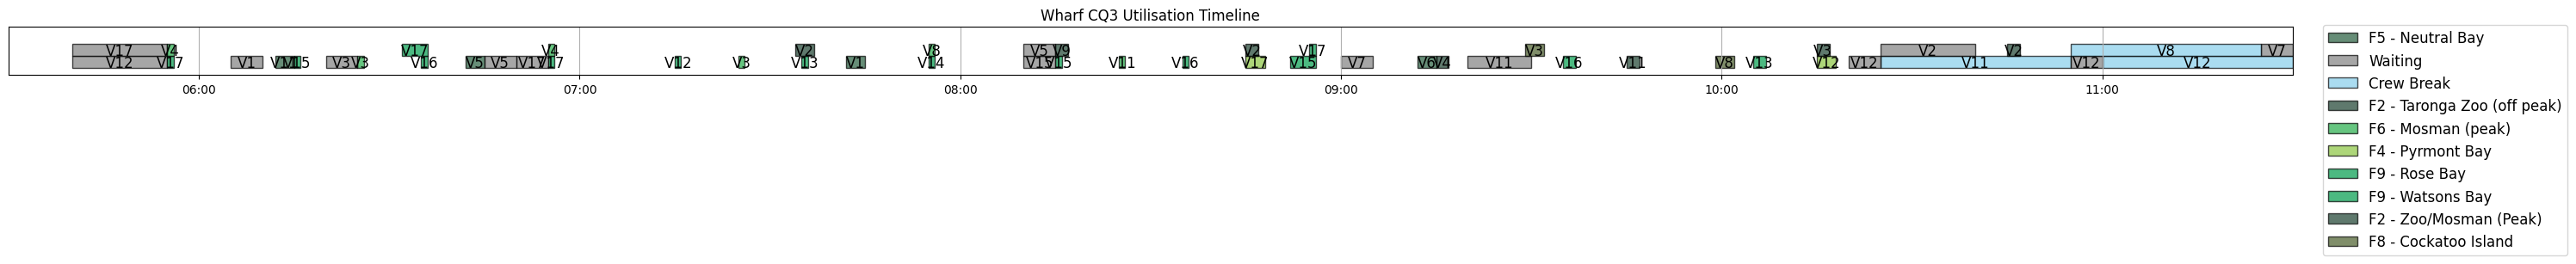

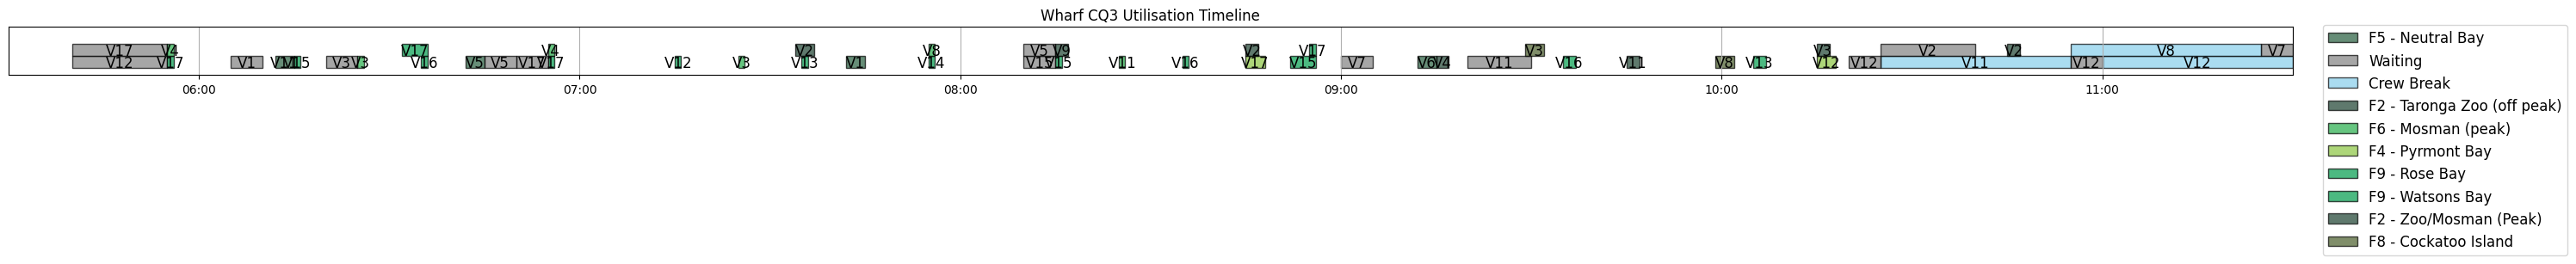

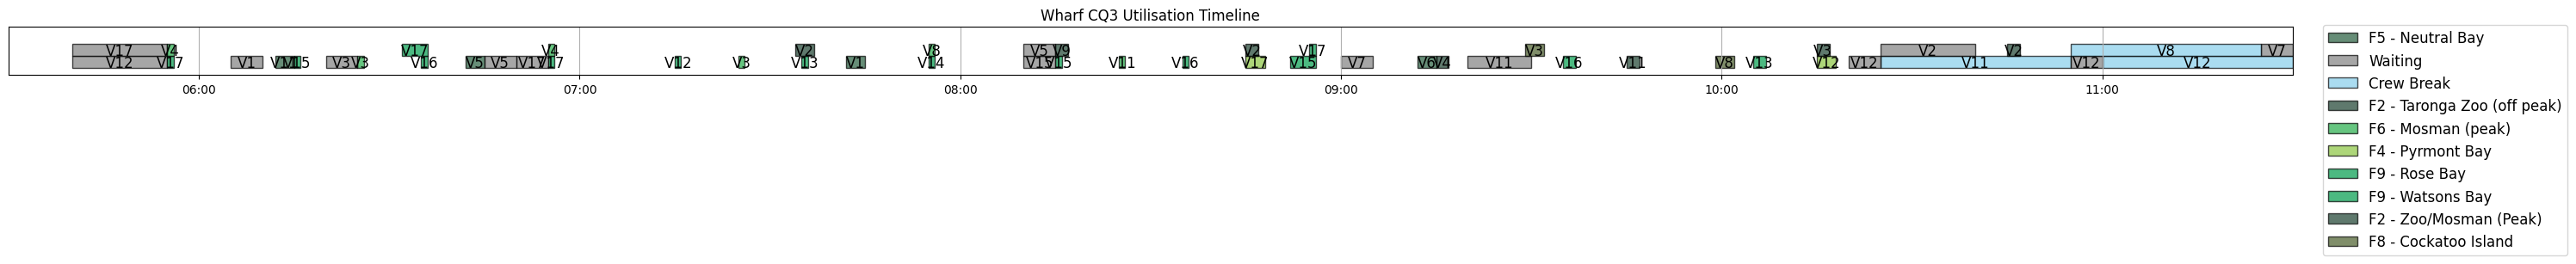

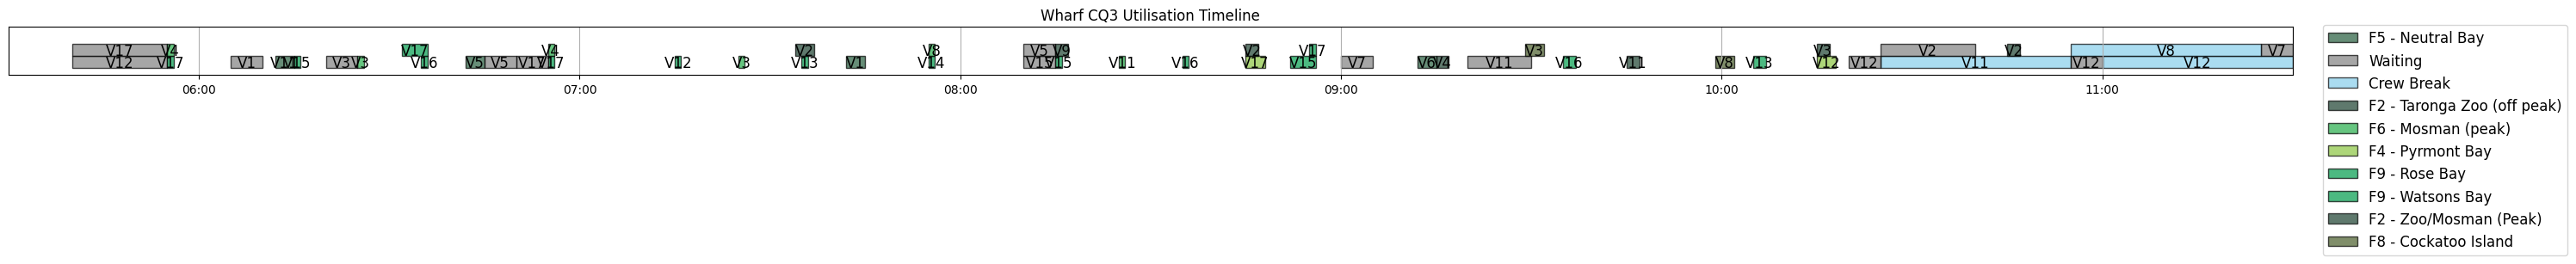

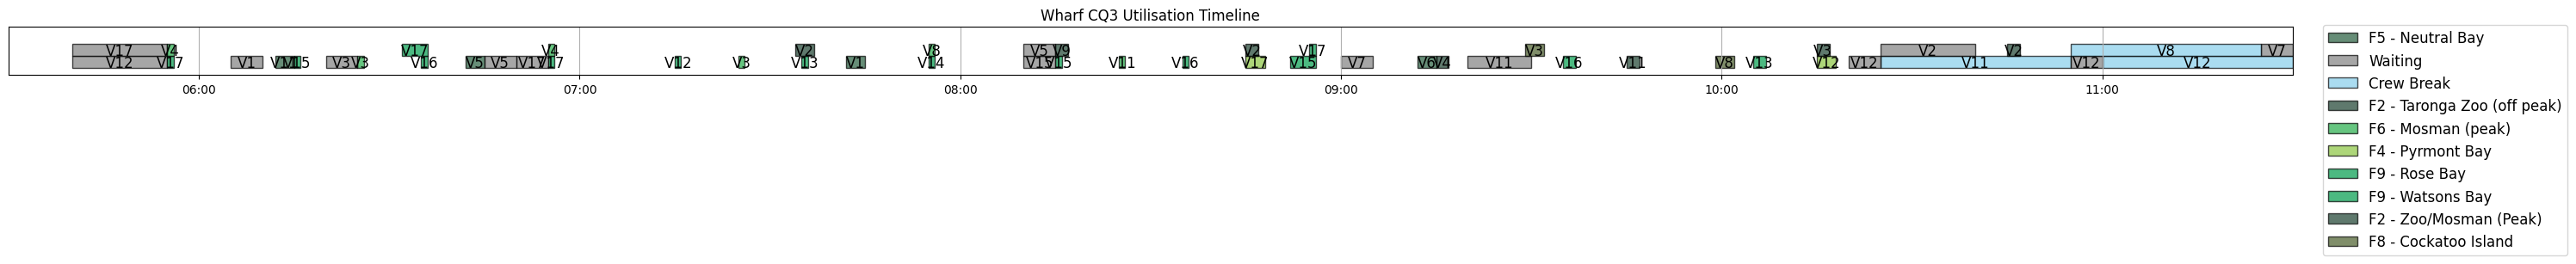

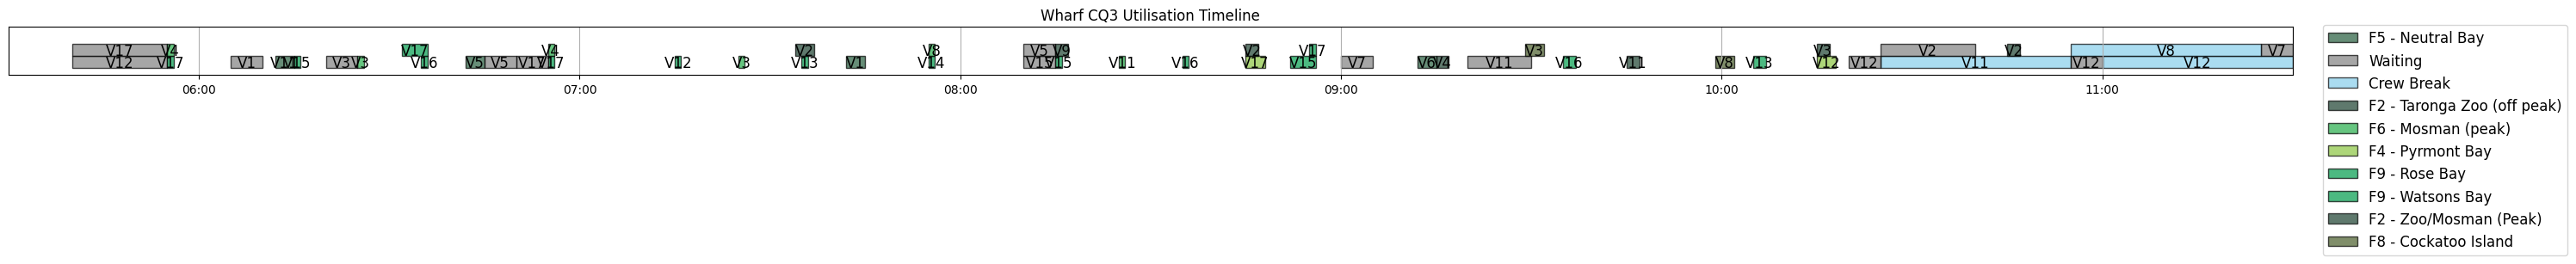

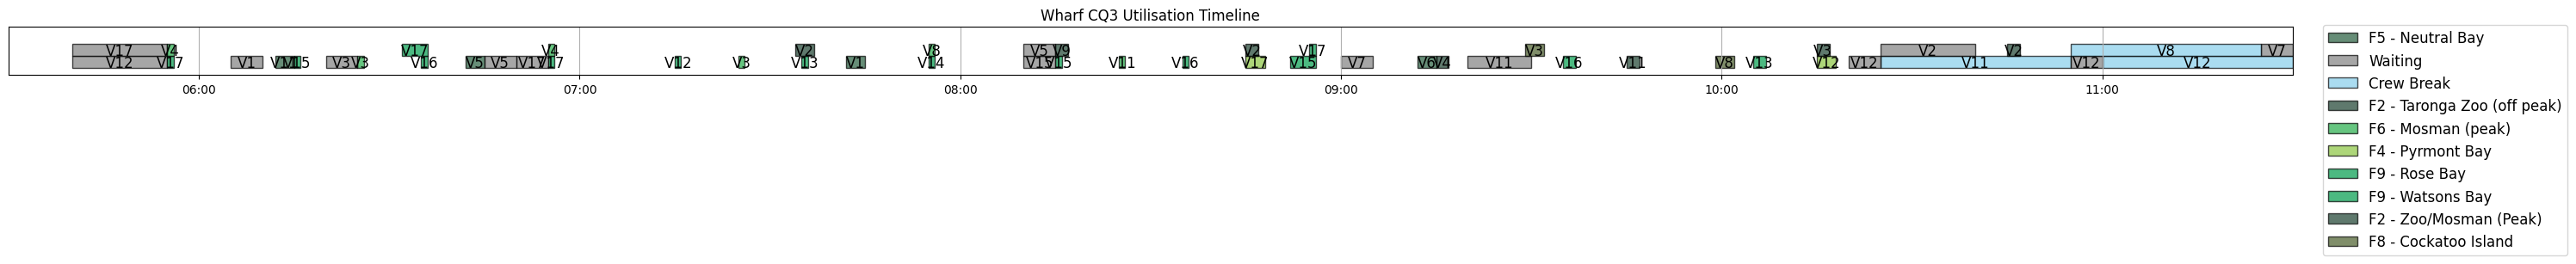

In [181]:
for wharf in ['CQ1','CQ2','CQ3','CQ4','CQ5','Bar1','Bar2','Bar4','Bar5']:
    visualise_wharf_utilization('CQ3',figsize=(30,2), dpi=100)

# zoom in

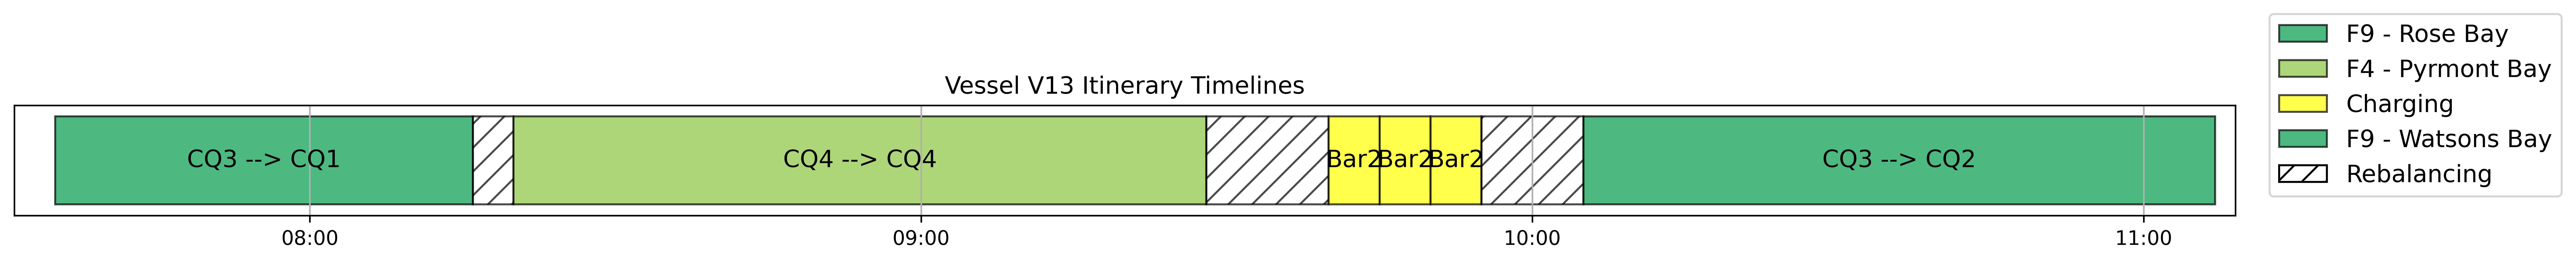

In [211]:
visualise_vessel_itinerarie('V13', display_start="07:31", display_end="11:09")

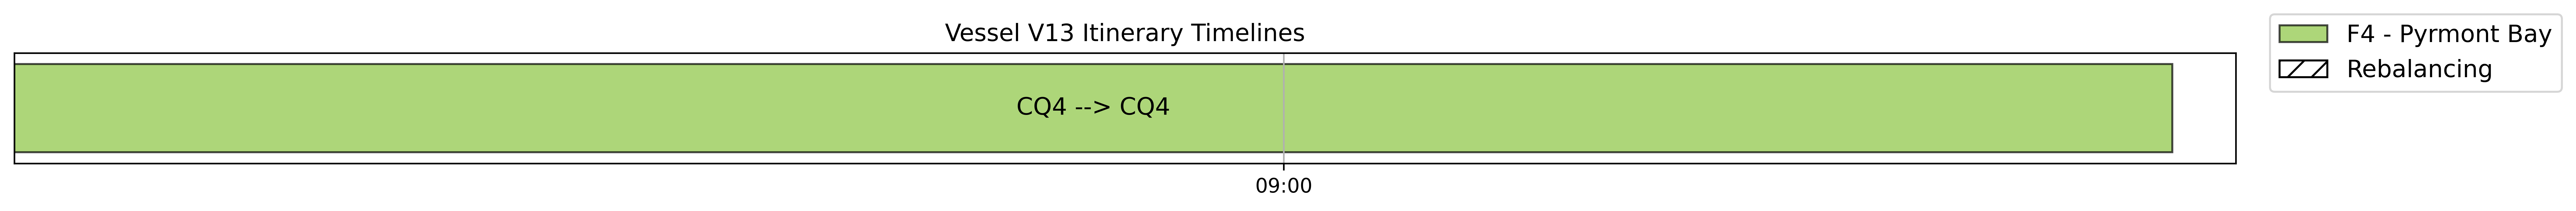

In [246]:
visualise_vessel_itinerarie('V13',display_start="08:20", display_end="9:30")

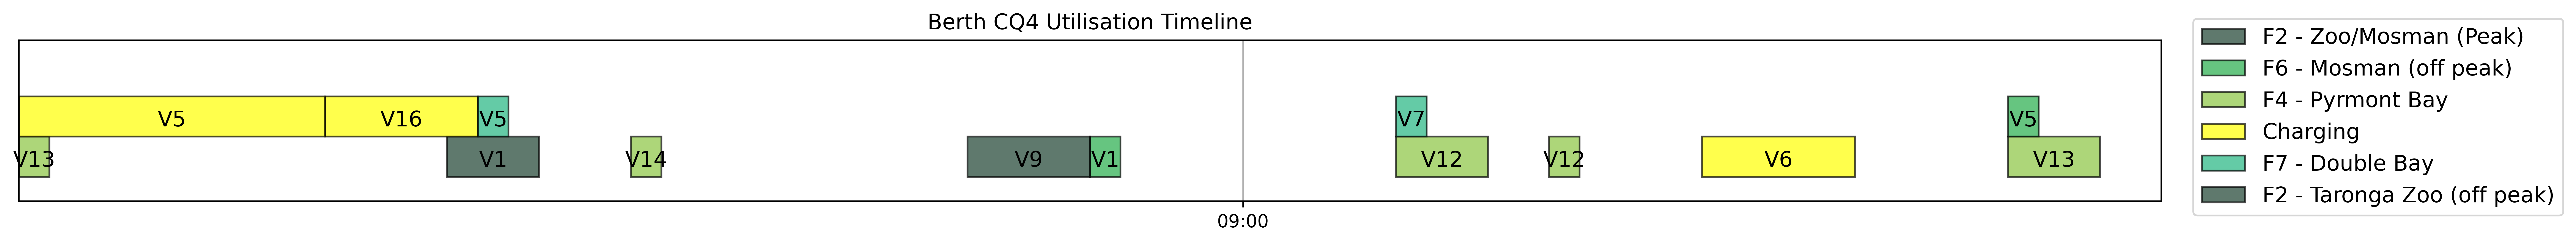

In [249]:
visualise_wharf_utilization('CQ4',figsize=(20,2), display_start="08:20", display_end="9:30")

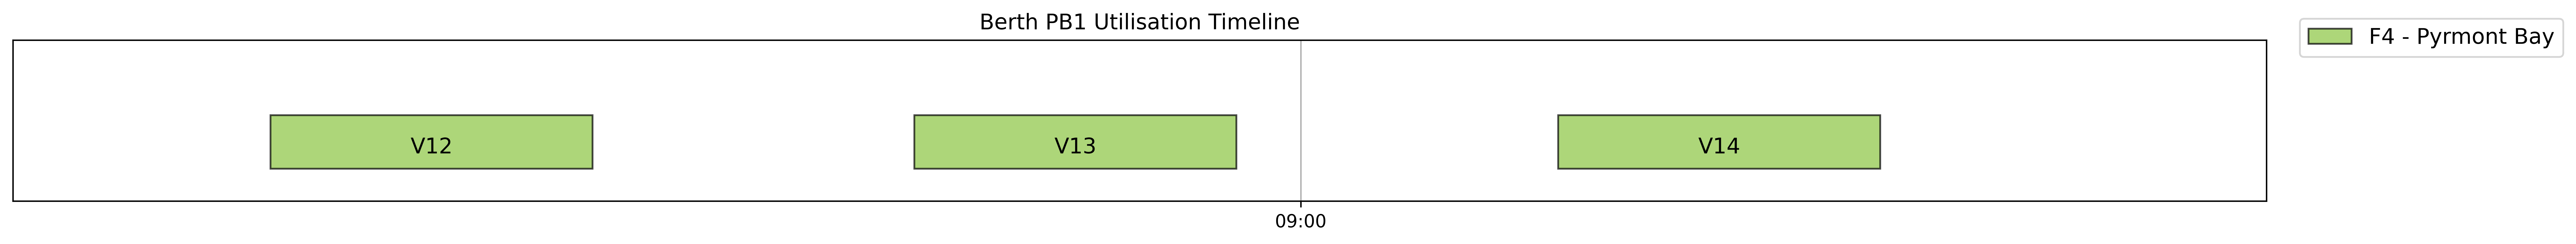

In [250]:
visualise_wharf_utilization('PB1',figsize=(20,2), display_start="08:20", display_end="9:30")

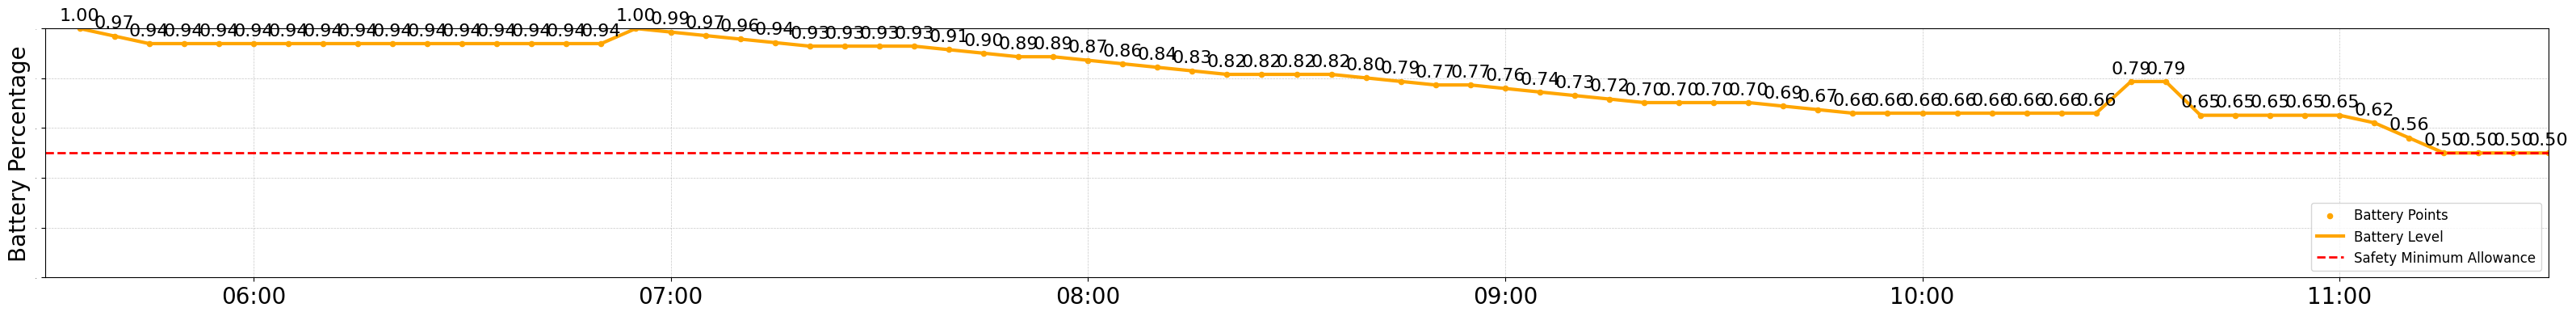

In [9]:
visualise_vessel_battery('V19', figsize=(40,4), dpi=100)#, display_start="08:10", display_end="09:00")

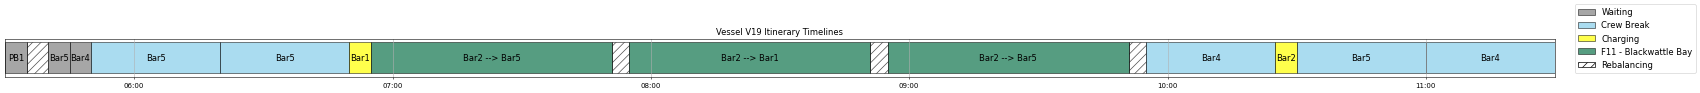

In [10]:
visualise_vessel_itinerarie(f'V19',figsize=(40,1), dpi=50)#, display_start="08:10", display_end="09:00")

In [16]:
list(range(14,15))

[14]